In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [2]:
rna_adata = sc.read_mtx("../../data/scRNAseq/BreastCancer/matrix.mtx.gz").T
rna_adata.var_names = pd.read_csv("../../data/scRNAseq/BreastCancer/features.tsv", header=None).iloc[:, 0].values
rna_adata.obs_names = pd.read_csv("../../data/scRNAseq/BreastCancer/barcodes.tsv", header=None).iloc[:, 0].values
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()

In [3]:
def validate_genes():
    from pyensembl import EnsemblRelease

    # release 77 uses human reference genome GRCh38
    data = EnsemblRelease(108)
    res = []
    valid_ids = []
    counter = 0
    for gid in rna_adata.var_names:
        try:
            name = data.gene_name_of_gene_id(gid)
            if len(name) == 0:
                raise Exception("None name")
            res.append(name)
            valid_ids.append(gid)
        except Exception as e:
            counter += 1
            
    print(f"Missed genes {counter}")    
    return res, valid_ids
gene_names, valid_ids = validate_genes()
rna_adata = rna_adata[:, valid_ids].copy()
rna_adata.var_names = gene_names
ids, cts = np.unique(rna_adata.var_names, return_counts=True)
deduplicated = [id for id,ct in zip(ids,cts) if ct==1]
rna_adata.var_names_make_unique()
rna_adata = rna_adata[:, deduplicated]

Missed genes 166


In [4]:
spa_adata = sc.read_mtx("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/matrix.mtx").T
spa_adata.var_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/features.tsv", header=None).iloc[:, 0].values
spa_adata.obs_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/barcodes.tsv", header=None).iloc[:, 0].values
df_obs = pd.read_csv("../../data/ST/BreastCancer/metadata/1142243F_metadata.csv", header=0, index_col=0)
spa_adata.obs = df_obs.loc[spa_adata.obs_names]
df_loc = pd.read_csv("../../data/ST/BreastCancer/spatial/1142243F_spatial/tissue_positions_list.csv", header=None, index_col=0).loc[spa_adata.obs_names]
spa_adata.obs['In_tissue'] = df_loc.iloc[:, 0]
spa_adata.obs['array_row'] = df_loc.iloc[:, 1]
spa_adata.obs['array_col'] = df_loc.iloc[:, 2]
spa_adata.obs['px_row'] = df_loc.iloc[:, 3]
spa_adata.obs['px_col'] = df_loc.iloc[:, 4]
# sc.pp.normalize_total(rna_adata)
# sc.pp.log1p(rna_adata)
sc.pp.filter_genes(spa_adata, min_cells=10)
spa_adata


AnnData object with n_obs × n_vars = 4784 × 17817
    obs: 'nCount_RNA', 'nFeature_RNA', 'patientid', 'subtype', 'Classification', 'In_tissue', 'array_row', 'array_col', 'px_row', 'px_col'
    var: 'n_cells'

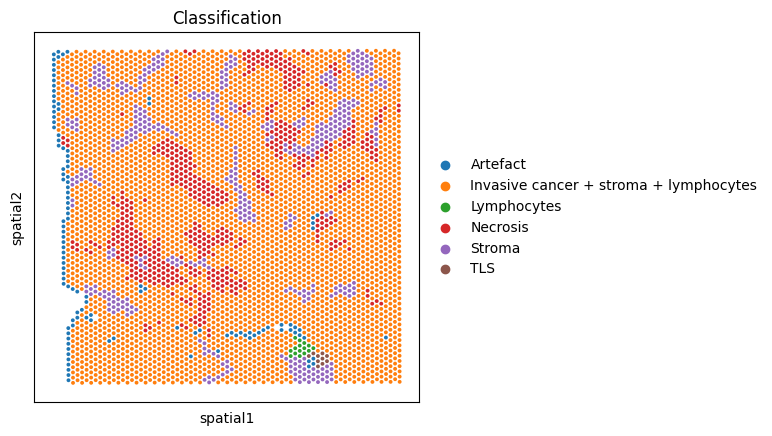

In [5]:
spa_adata.obsm['spatial'] = spa_adata.obs[['px_row', 'px_col']].values
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv("../../output/locations/breastcancer.csv", index=False)
sc.pl.spatial(spa_adata, color='Classification', spot_size=200)

In [6]:
sc.pp.normalize_total(spa_adata)
sc.pp.log1p(spa_adata)
sq.gr.spatial_neighbors(spa_adata, coord_type='grid', n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)


In [7]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
rna_adata, spa_adata


(AnnData object with n_obs × n_vars = 35276 × 3424
     obs: 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'hvg',
 AnnData object with n_obs × n_vars = 4784 × 17817
     obs: 'nCount_RNA', 'nFeature_RNA', 'patientid', 'subtype', 'Classification', 'In_tissue', 'array_row', 'array_col', 'px_row', 'px_col'
     var: 'n_cells'
     uns: 'Classification_colors', 'log1p', 'spatial_neighbors', 'moranI'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [8]:
raw_spatial_df  = pd.DataFrame(spa_adata.X.toarray(), columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X.toarray(), columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((4784, 17817), (35276, 3424), (2915,))

In [9]:
spa_adata.uns['moranI'].I

IGLC2         0.671922
IGKC          0.641348
MTRNR2L8      0.608629
AL627171.2    0.606129
IGHG3         0.604715
                ...   
EEF2K        -0.021831
CLK4         -0.021878
FBXL17       -0.022593
FSD1L        -0.022947
SNHG12       -0.024831
Name: I, Length: 17817, dtype: float64

In [10]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X.toarray(), columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X.toarray(), columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((4784, 2915), (35276, 2915), (2915,))

In [11]:
np.random.seed(42)
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 2815)

In [12]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        n_epochs=2500,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        mapping_mode='lowrank',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        signature_mode='cluster',
        mapping_mode='full',
        n_epochs=2500,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_other", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 2815


[TransImp] Epoch: 2500/2500, loss: 0.403366, (IMP) 0.402884, (SPA) 1.0 x 0.000482: 100%|██████████| 2500/2500 [00:13<00:00, 179.77it/s]


Median correlation: 0.020429264421515797 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.820055, (IMP) 0.820055, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 473.03it/s]


Median correlation: 0.031387165408532806 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.393489, (IMP) 0.393489, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:10<00:00, 248.31it/s]


Median correlation: 0.019587036087697608 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.822463, (IMP) 0.820833, (SPA) 1.0 x 0.001630: 100%|██████████| 2500/2500 [00:08<00:00, 293.81it/s]


Median correlation: 0.029407482771047575 (TransImpClsSpa)
			0.011801299586824208 (stPlus)
			0.011289589828233654 (spaGE)


INFO:root:100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:100 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 100 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.321, KL reg: 0.058
Score: 0.537, KL reg: 0.003
Score: 0.538, KL reg: 0.003
Score: 0.538, KL reg: 0.003
Score: 0.539, KL reg: 0.003
Score: 0.539, KL reg: 0.003
Score: 0.539, KL reg: 0.003
Score: 0.539, KL reg: 0.003
Score: 0.539, KL reg: 0.003


INFO:root:Saving results..


Score: 0.539, KL reg: 0.003
			0.033069624528385896 (Tangram)
0.020429264421515797 (TransImpSpa) 0.019587036087697608 (TransImp) 0.031387165408532806 (TransImpCls) 0.029407482771047575 (TransImpClsSpa) 0.011801299586824208 (stPlus) 0.011289589828233654 (spaGE) 0.033069624528385896 (Tangram)


In [13]:
df_transImp.to_csv('../../output/breastcancerext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/breastcancerext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/breastcancerext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/breastcancerext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/breastcancerext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/breastcancerext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/breastcancerext_singlecell_Tangram.csv')
test_spatial_df.to_csv('../../output/breastcancerext_singlecell_truth.csv')

In [14]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [15]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/breastcancerext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/breastcancerext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [16]:
spa_shared

AnnData object with n_obs × n_vars = 4784 × 2915
    obs: 'nCount_RNA', 'nFeature_RNA', 'patientid', 'subtype', 'Classification', 'In_tissue', 'array_row', 'array_col', 'px_row', 'px_col'
    var: 'n_cells'
    uns: 'Classification_colors', 'log1p', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [17]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X.toarray(), columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [00:38<00:00,  5.51s/it]


In [18]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([14948,  2869]))

In [19]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
A2M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AARD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AASS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.359627
ABAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.492347
ABCA1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.465251
...,...,...,...,...,...,...,...,...
ZSCAN31,0.357571,0.378967,0.160255,0.018647,0.304102,0.145537,0.470674,0.000002
ZSWIM6,0.327886,0.327335,0.157158,0.011633,0.293033,0.136908,0.360313,0.097317
ZUP1,0.320626,0.323729,0.151162,0.006798,0.267739,0.117056,0.345653,0.257988
ZWINT,0.305014,0.310863,0.143129,0.004753,0.116562,0.092476,0.305809,0.086304


(Tangram) Valid genes: 2239/2815
Tangram
FPR: 0.928624
(TransImp) Valid genes: 2239/2815
TransImp
FPR: 0.949963
(TransImpSpa) Valid genes: 2239/2815
TransImpSpa
FPR: 0.899926
(spaGE) Valid genes: 2239/2815
spaGE
FPR: 0.757910
(stPlus) Valid genes: 2239/2815
stPlus
FPR: 0.967623


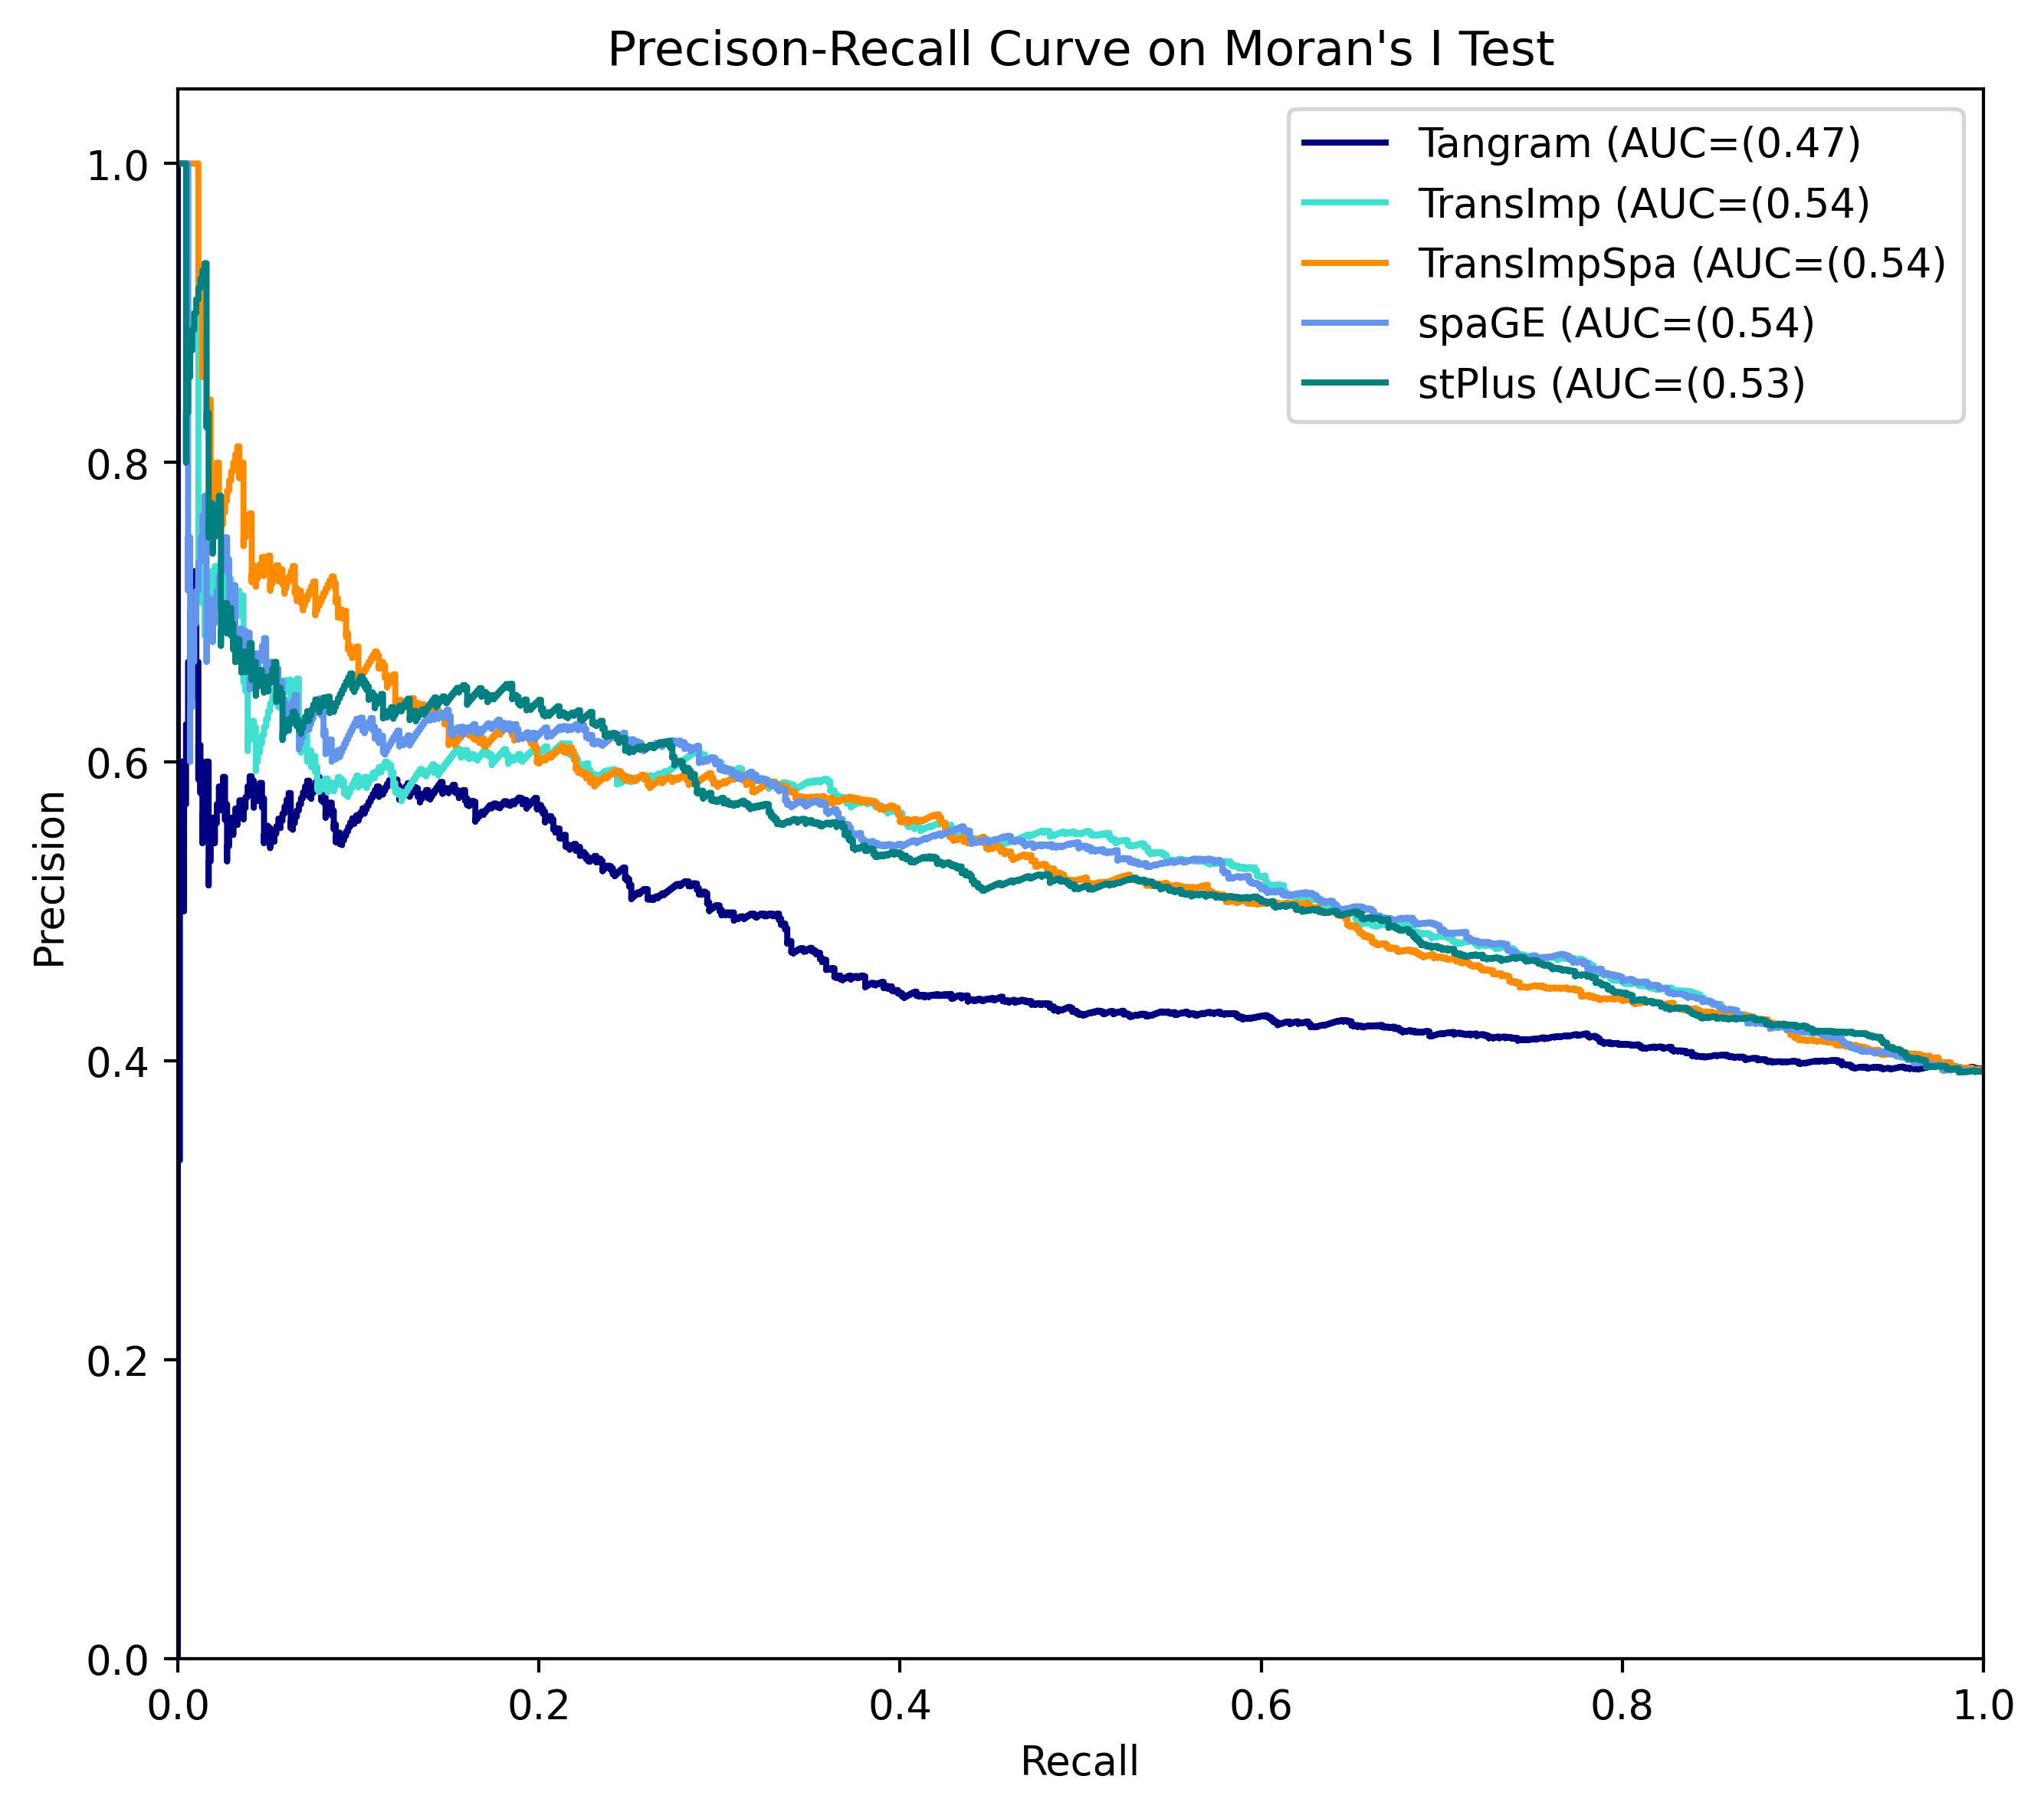

In [20]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(rec, prec)
    
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({auc_score:.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 2239/2815
Tangram
FPR: 0.928624
(TransImp) Valid genes: 2239/2815
TransImp
FPR: 0.949963
(TransImpSpa) Valid genes: 2239/2815
TransImpSpa
FPR: 0.899926
(spaGE) Valid genes: 2239/2815
spaGE
FPR: 0.757910
(stPlus) Valid genes: 2239/2815
stPlus
FPR: 0.967623


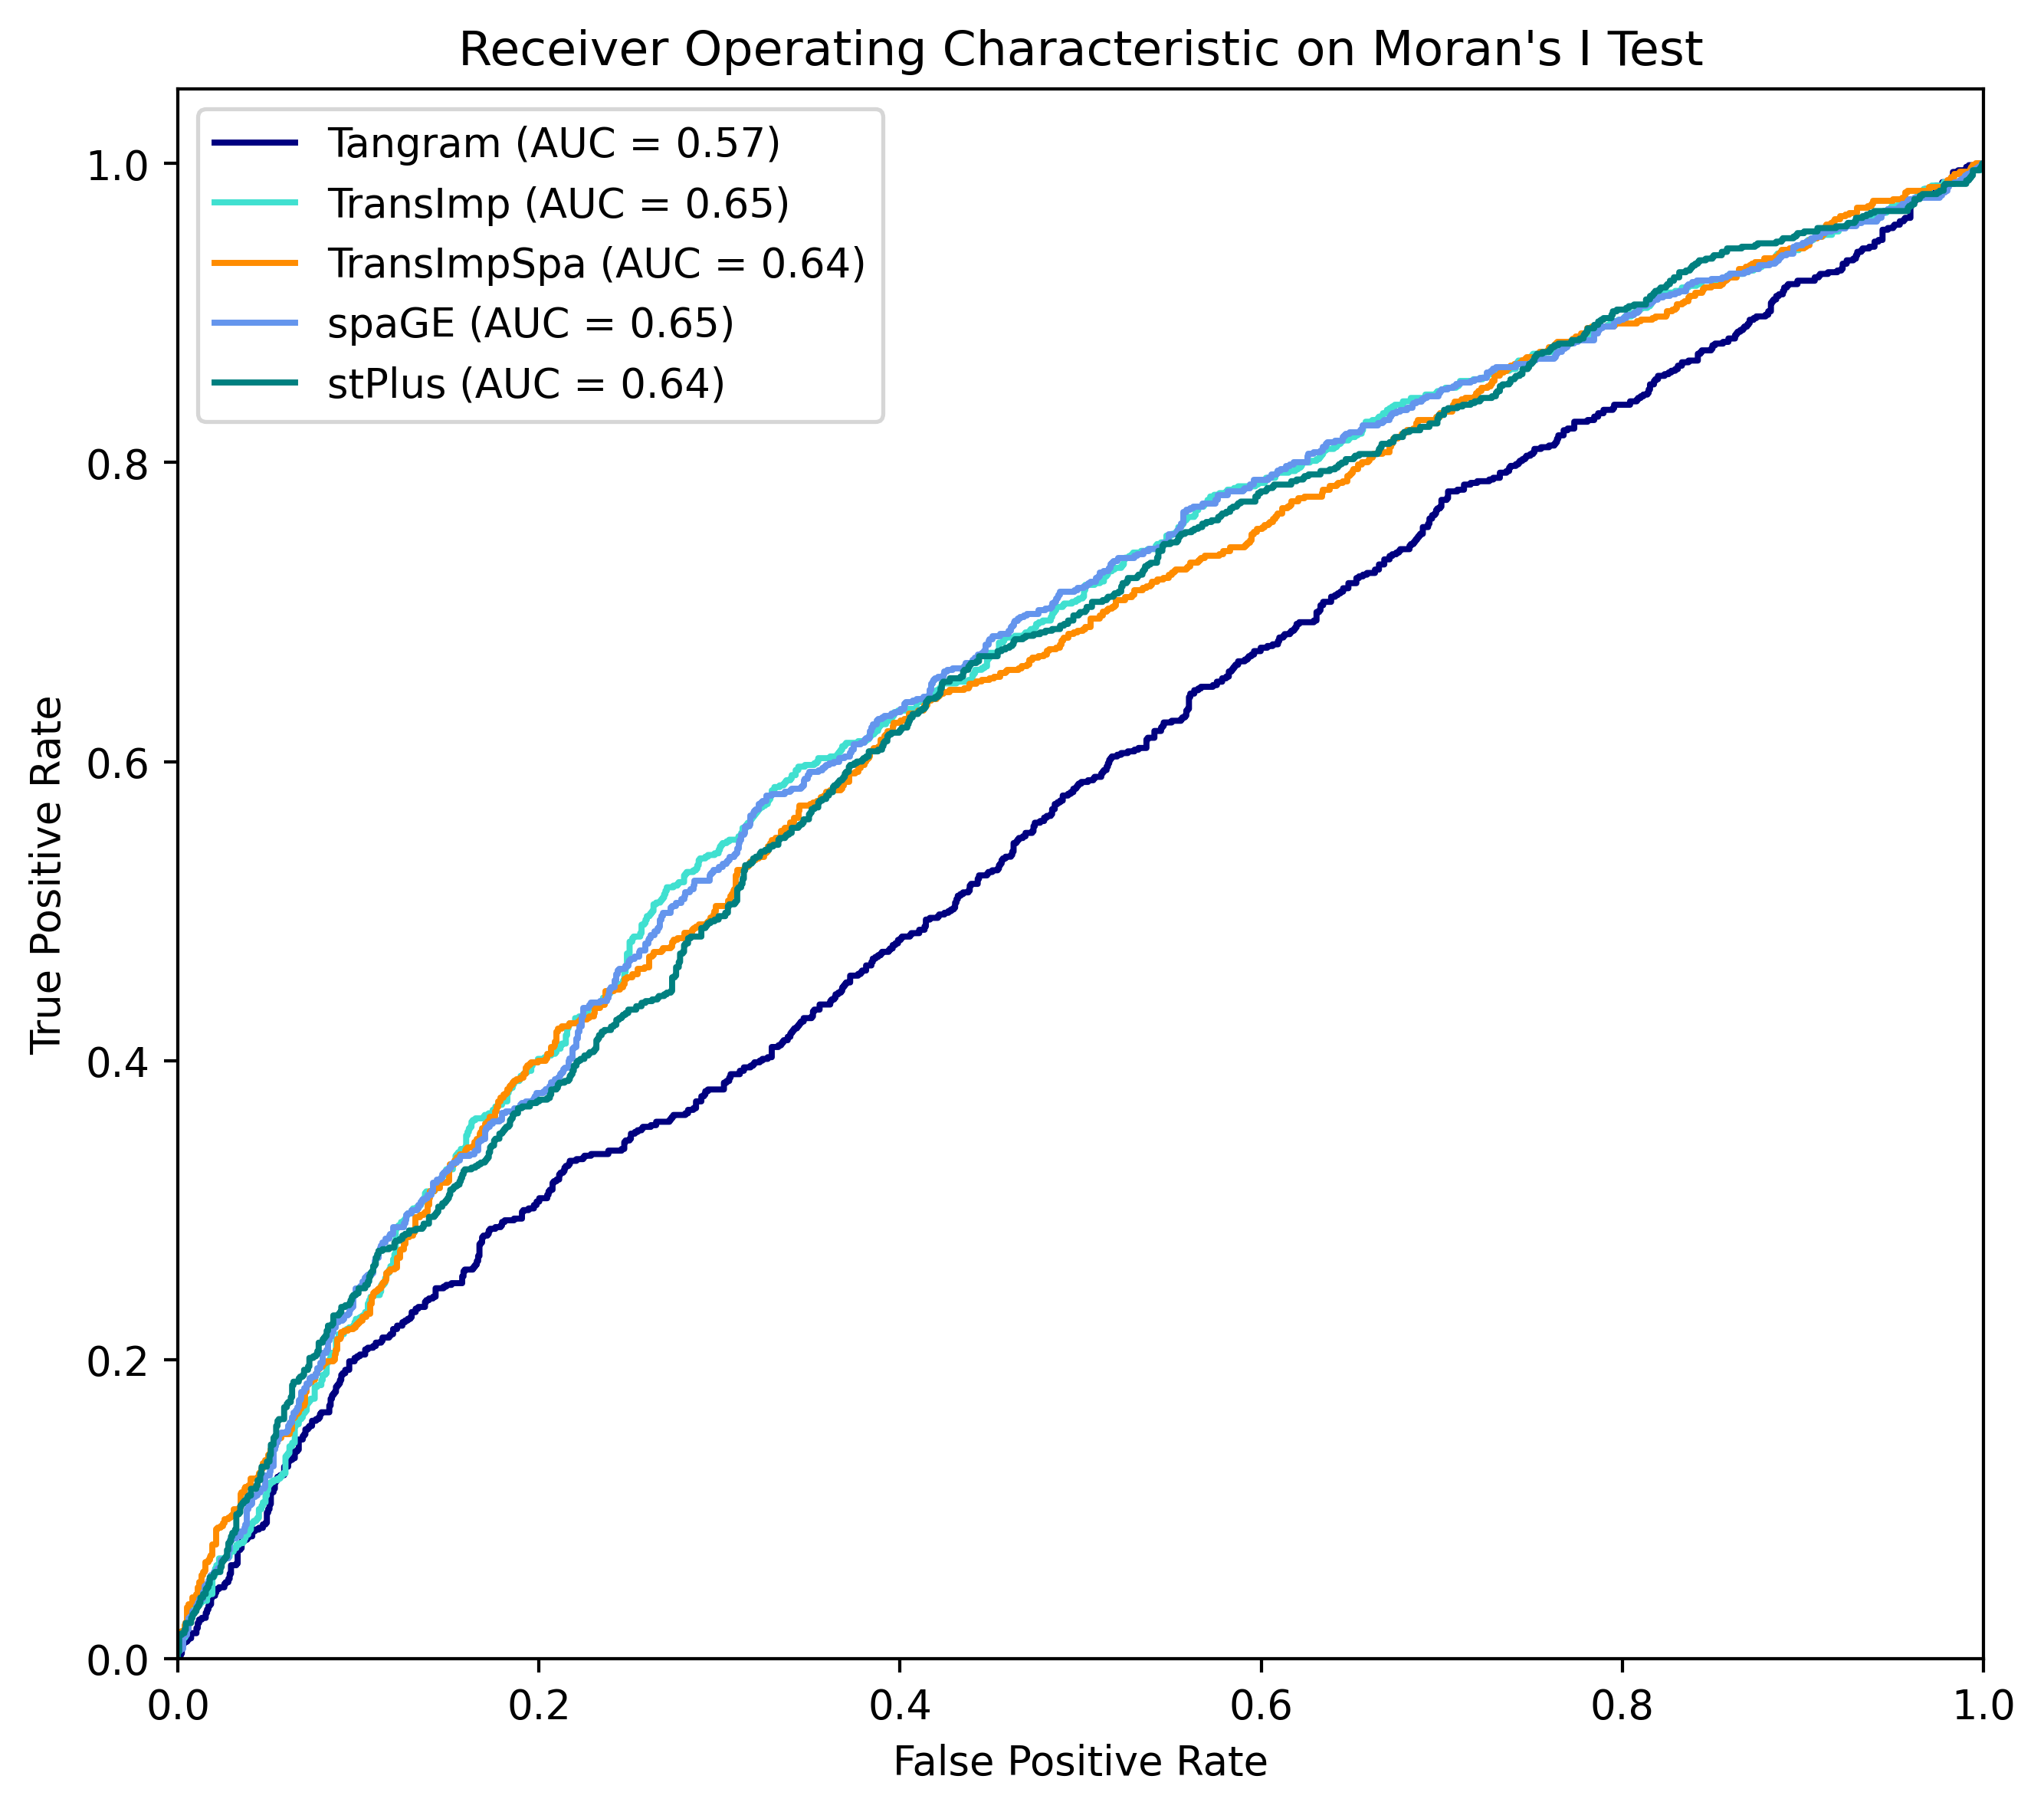

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [21]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {auc_score:.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 2239/2815
Tangram
FPR: 0.928624
prec: 0.39961941008563273, recl: 0.9545454545454546,  F1: 0.5633802816901409
(TransImp) Valid genes: 2239/2815
TransImp
FPR: 0.949963
prec: 0.3984156570363467, recl: 0.9715909090909091,  F1: 0.565102445472571
(TransImpCls) Valid genes: 2239/2815
TransImpCls
FPR: 0.941133
prec: 0.400093808630394, recl: 0.9693181818181819,  F1: 0.5664010624169986
(TransImpClsSpa) Valid genes: 2239/2815
TransImpClsSpa
FPR: 0.735099
prec: 0.4039379474940334, recl: 0.7693181818181818,  F1: 0.529733959311424
(TransImpSpa) Valid genes: 2239/2815
TransImpSpa
FPR: 0.899926
prec: 0.4004901960784314, recl: 0.928409090909091,  F1: 0.5595890410958905
(spaGE) Valid genes: 2239/2815
spaGE
FPR: 0.757910
prec: 0.40702360391479564, recl: 0.803409090909091,  F1: 0.5403133358807796
(stPlus) Valid genes: 2239/2815
stPlus
FPR: 0.967623
prec: 0.3989945155393053, recl: 0.9920454545454546,  F1: 0.5691003911342895


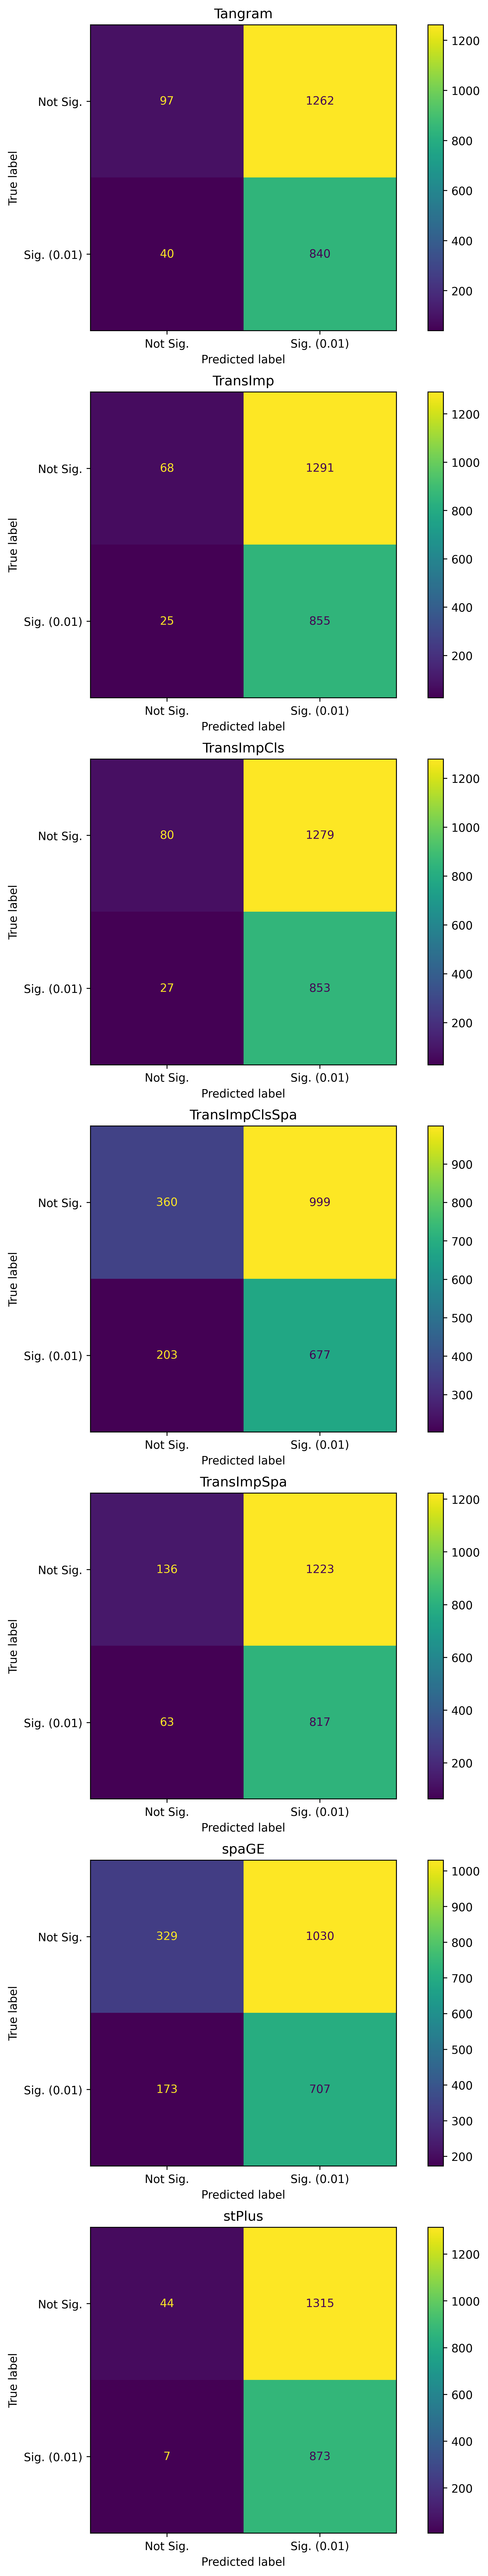

In [22]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [23]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r breastcancer

[1] "transImpute"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 4784 
## number of total genes: 2815 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "transImpSpa"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 4784 
## number of total genes: 2815 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
##

In [24]:
methods = ["truth", "transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus", "Tangram"]
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None
name_mapping = {"Tangram":"Tangram", "transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
for md in methods:
    df = pd.read_csv(f"../../output/sparkx_breastcancer_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    if md in name_mapping:
        md = name_mapping[md]
    
    diff_genes = np.setdiff1d(ca_genes, df.index.values)
    if len(diff_genes) > 0:
        df = df.append(pd.DataFrame(np.ones((len(diff_genes), df.shape[1])), index=diff_genes, columns=df.columns))
        
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

(                 truth      TransImp   TransImpSpa   TransImpCls  \
 A2M      2.058804e-102  2.087597e-31  5.520390e-21  4.141132e-14   
 AARD     5.421790e-116  8.097393e-32  3.758965e-23  1.128589e-23   
 AASS      6.569980e-01  3.023803e-12  3.330669e-16  1.483819e-25   
 ABAT      8.849412e-01  8.302149e-05  6.821096e-05  4.020743e-03   
 ABCA1     5.727186e-02  4.107825e-15  2.352871e-18  7.055587e-27   
 ...                ...           ...           ...           ...   
 ZSCAN31   7.407125e-08  3.394055e-05  2.078327e-06  1.776357e-15   
 ZSWIM6    4.437408e-04  8.770762e-15  1.018082e-06  1.419985e-26   
 ZUP1      2.184716e-01  6.076528e-10  7.347403e-05  2.048139e-12   
 ZWINT     1.142100e-02  1.206682e-21  4.440892e-16  1.976197e-13   
 ZYG11B    9.830924e-01  3.055334e-13  9.869339e-11  3.012618e-41   
 
          TransImpClsSpa         spaGE        stPlus       Tangram  
 A2M        9.132362e-12  4.796052e-11  3.342349e-11  4.691449e-09  
 AARD       4.624294e-20  2.8544

(Tangram) Valid genes: 2815/2815
Tangram
FPR: 0.922657
(TransImp) Valid genes: 2815/2815
TransImp
FPR: 0.847794
(TransImpSpa) Valid genes: 2815/2815
TransImpSpa
FPR: 0.840853
(spaGE) Valid genes: 2815/2815
spaGE
FPR: 0.770947
(stPlus) Valid genes: 2815/2815
stPlus
FPR: 0.849777


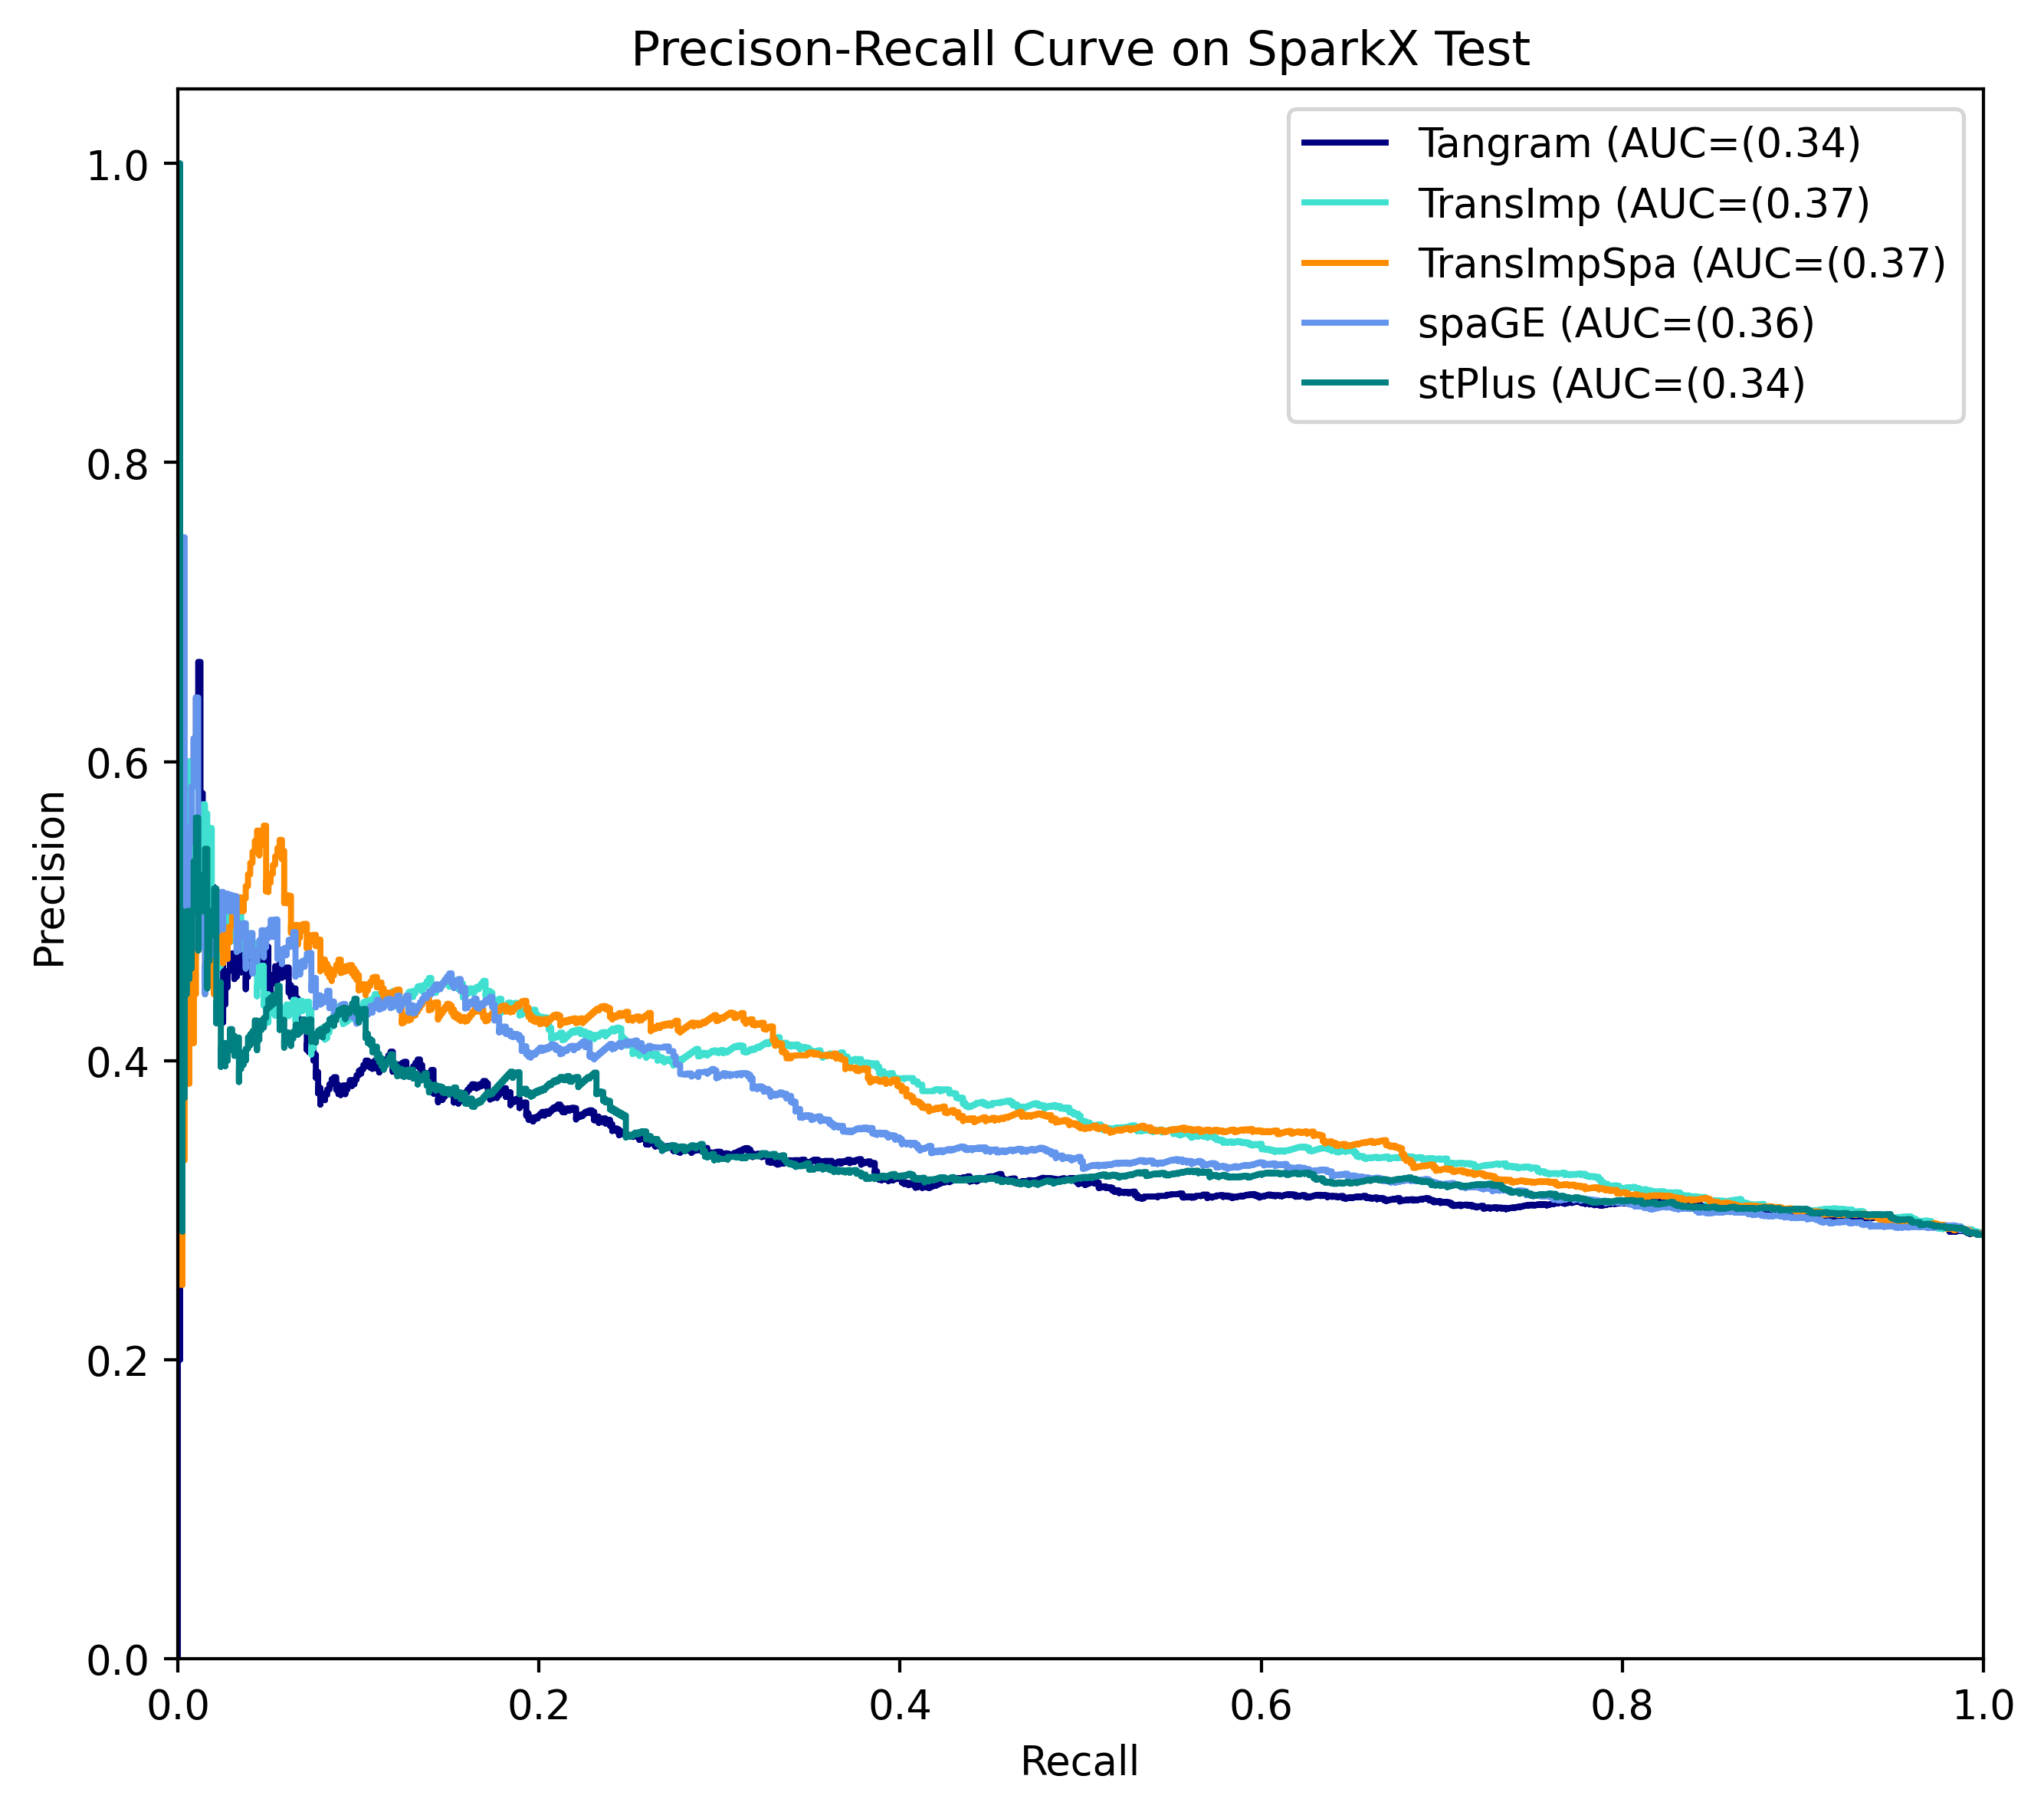

In [25]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    score = -np.log(df_sparkx_cmbpvals[method][sel].values + 1e-100)
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    
        
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
        
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 2815/2815
Tangram
FPR: 0.922657
(TransImp) Valid genes: 2815/2815
TransImp
FPR: 0.847794
(TransImpSpa) Valid genes: 2815/2815
TransImpSpa
FPR: 0.840853
(spaGE) Valid genes: 2815/2815
spaGE
FPR: 0.770947
(stPlus) Valid genes: 2815/2815
stPlus
FPR: 0.849777


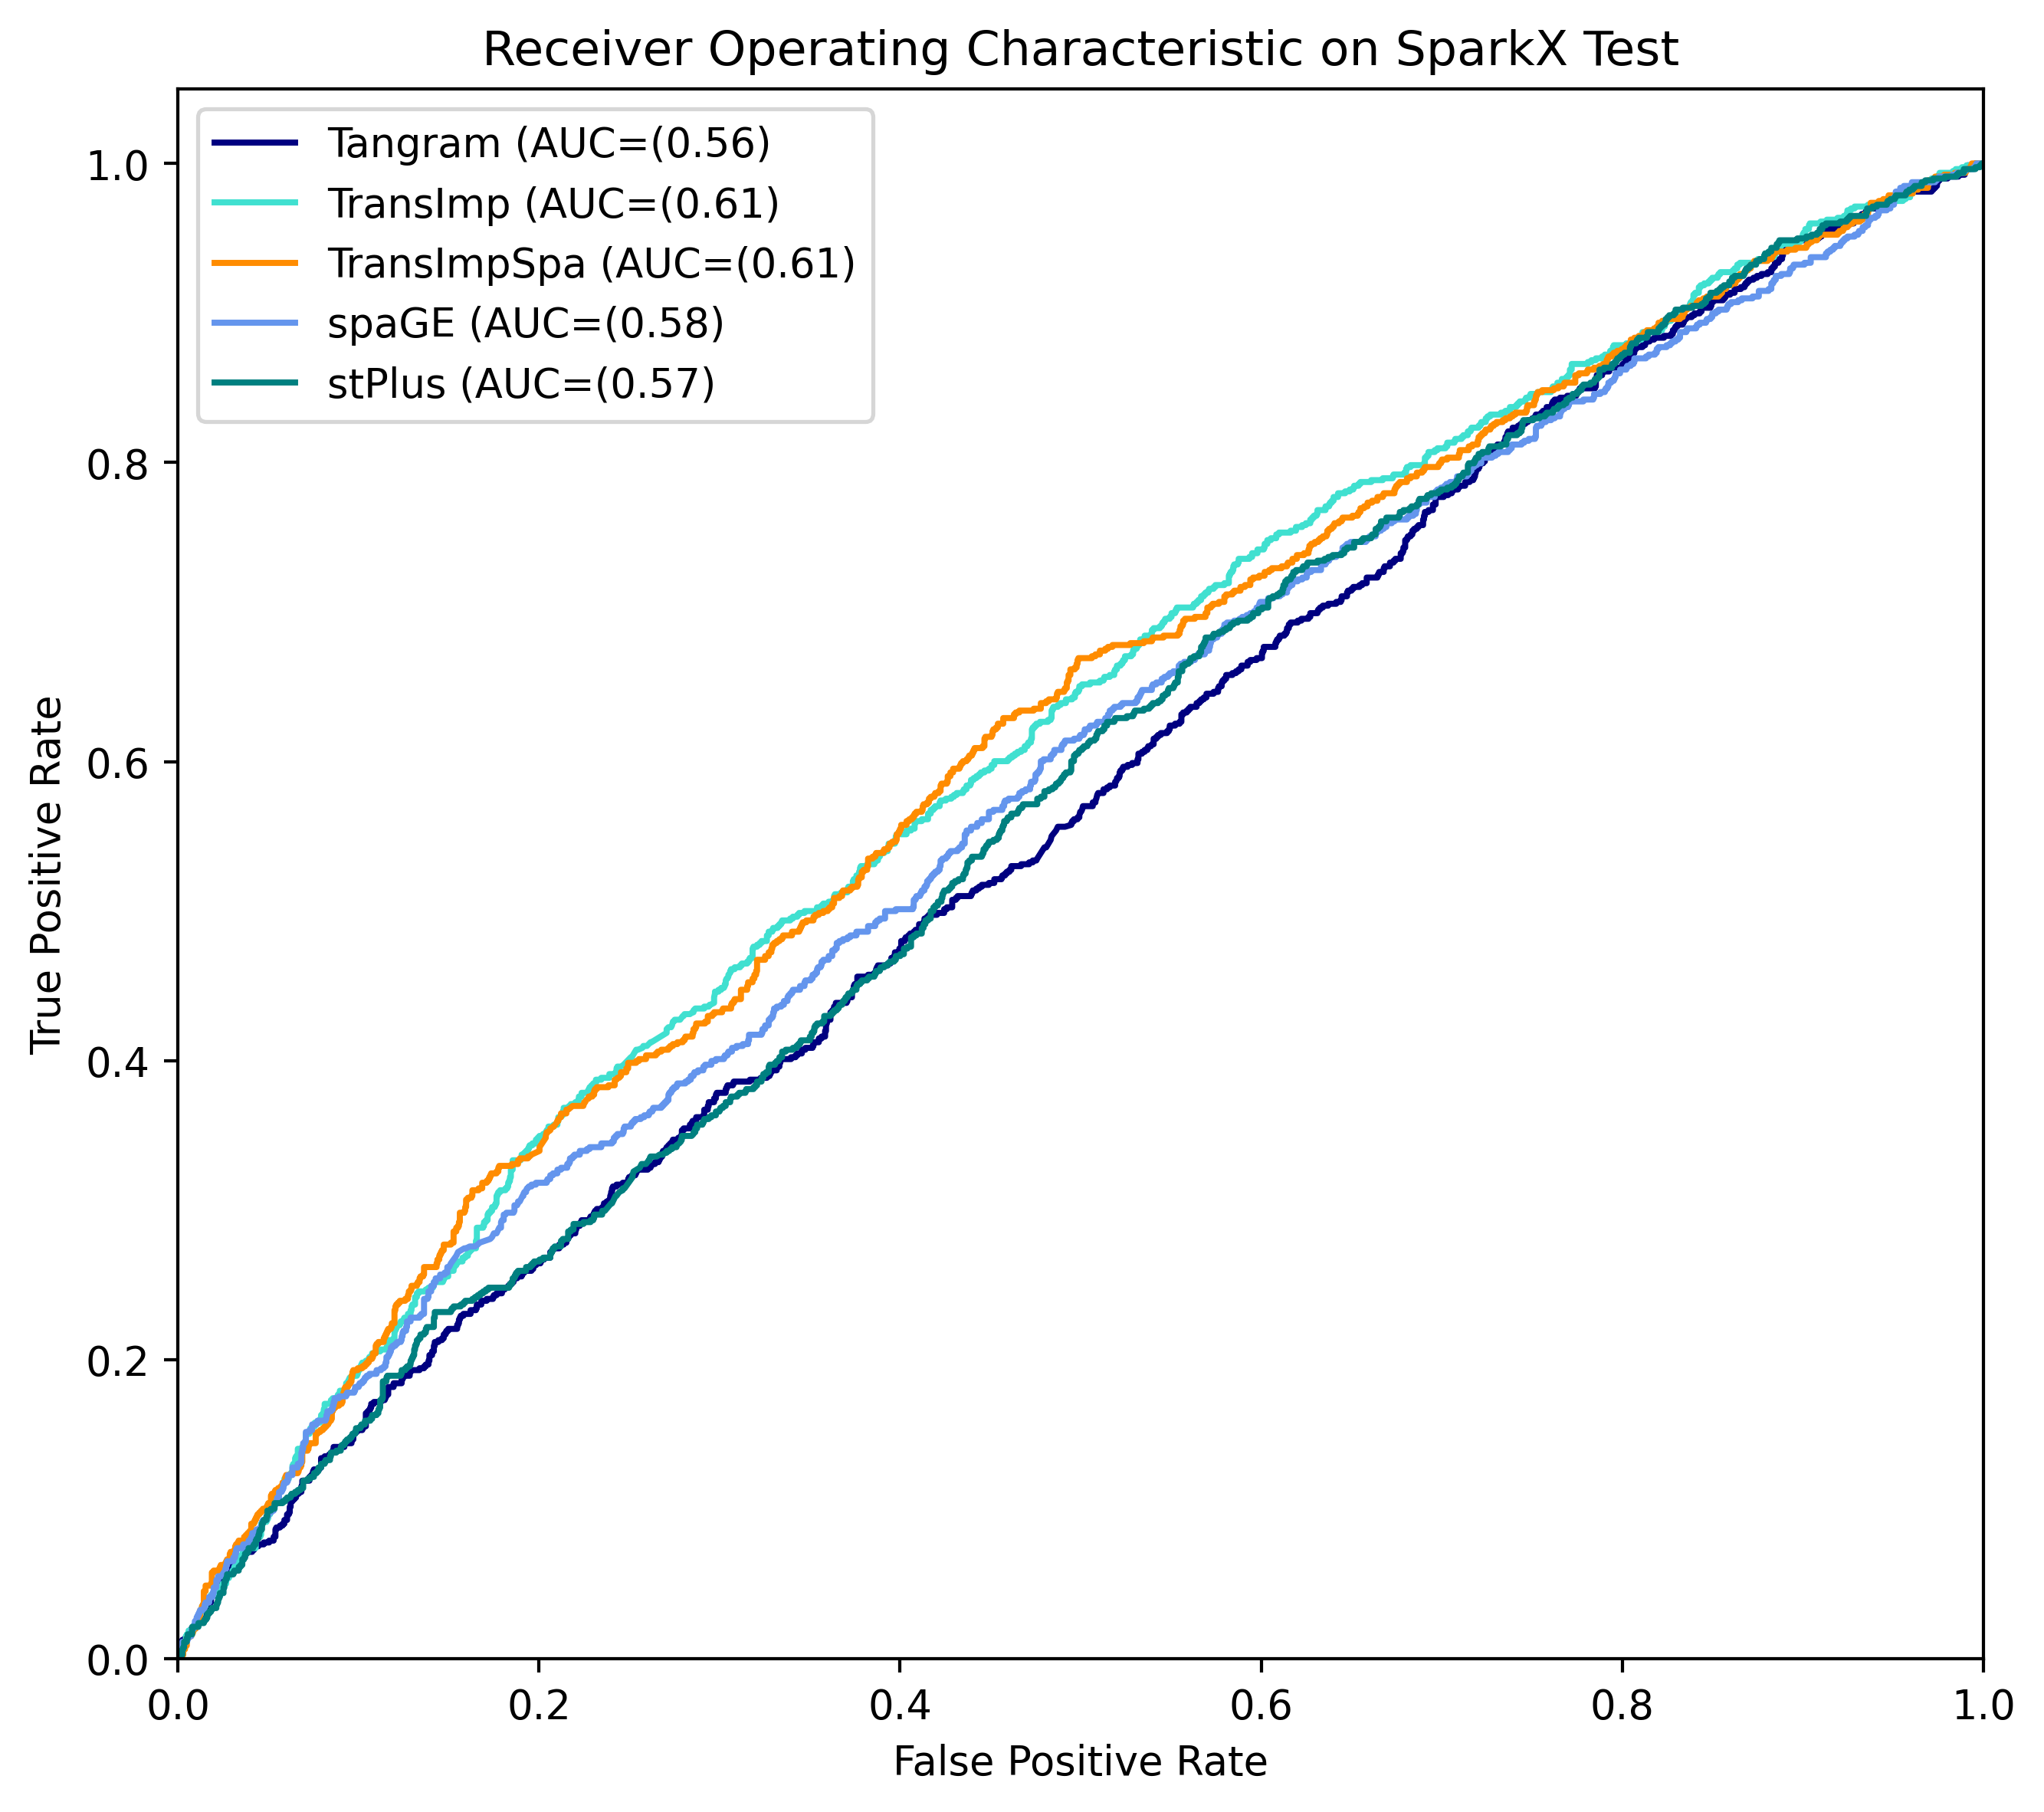

In [26]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  np.log(1 - df_sparkx_adjpvals[method][sel].values + 1e-6)
    score = -np.log(df_sparkx_cmbpvals[method][sel].values + 1e-100)
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 2815/2815
Tangram
FPR: 0.922657
prec: 0.29104761904761905, recl: 0.9573934837092731,  F1: 0.4463920537540169
(TransImp) Valid genes: 2815/2815
TransImp
FPR: 0.847794
prec: 0.3006134969325153, recl: 0.9210526315789473,  F1: 0.45328399629972244
(TransImpCls) Valid genes: 2815/2815
TransImpCls
FPR: 0.888944
prec: 0.292423046566693, recl: 0.9285714285714286,  F1: 0.4447779111644658
(TransImpClsSpa) Valid genes: 2815/2815
TransImpClsSpa
FPR: 0.845315
prec: 0.2963268675196038, recl: 0.899749373433584,  F1: 0.44582427817448
(TransImpSpa) Valid genes: 2815/2815
TransImpSpa
FPR: 0.840853
prec: 0.2985938792390405, recl: 0.9047619047619048,  F1: 0.4490049751243781
(spaGE) Valid genes: 2815/2815
spaGE
FPR: 0.770947
prec: 0.30143755615453727, recl: 0.8408521303258145,  F1: 0.4437830687830687
(stPlus) Valid genes: 2815/2815
stPlus
FPR: 0.849777
prec: 0.2984036021285305, recl: 0.9135338345864662,  F1: 0.44986115396482573


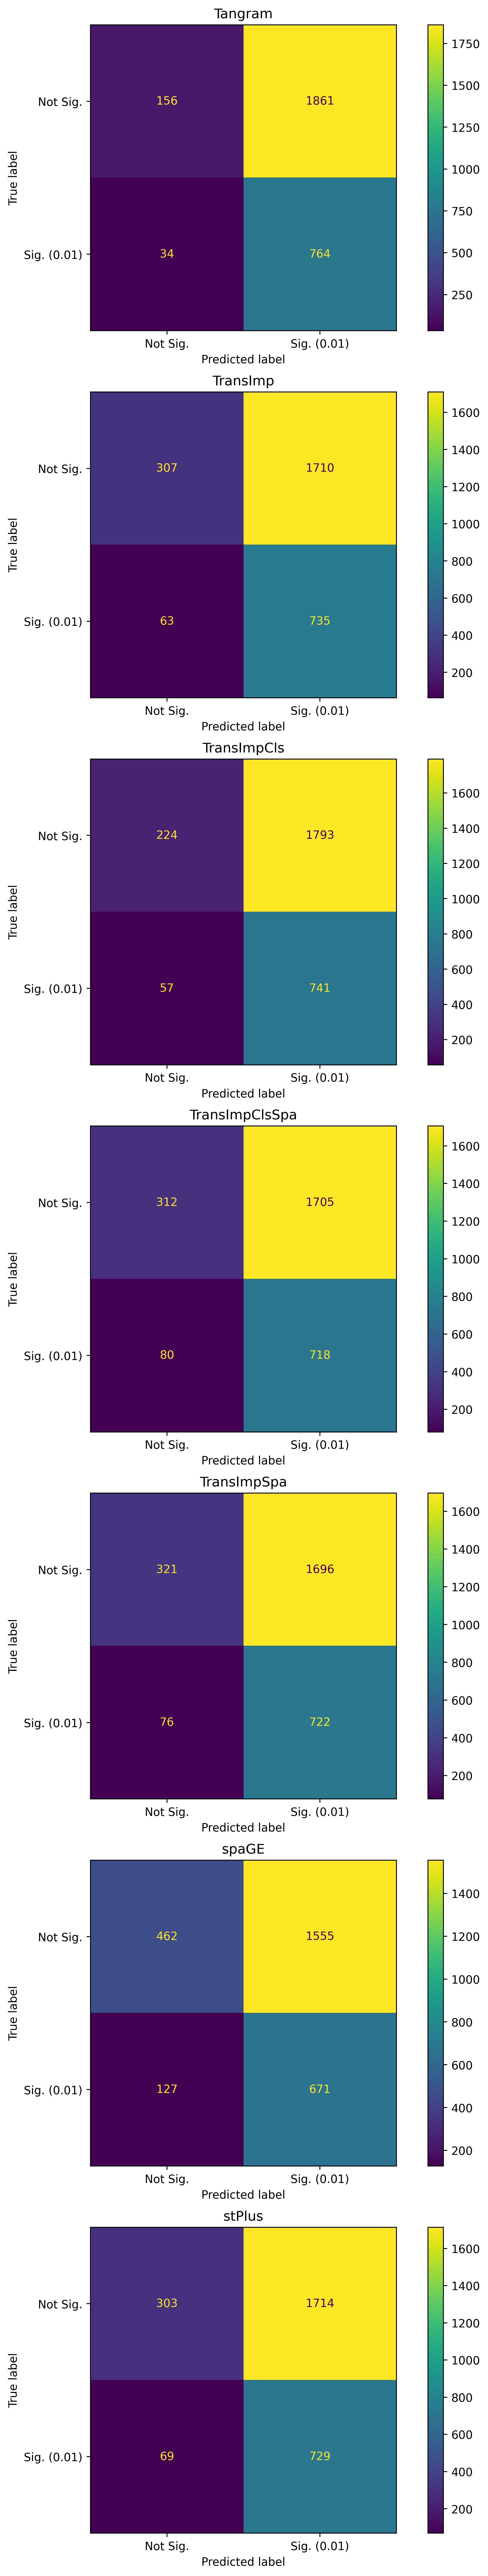

In [27]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()